In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
import missingno as msno

from imblearn.over_sampling import SMOTE
import joblib

from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, auc, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import KFold
from scipy import stats
import numpy as np
import pandas as pd

from sklearn.feature_selection import mutual_info_classif

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance
from lime.lime_tabular import LimeTabularExplainer

import warnings
from sklearn.exceptions import UndefinedMetricWarning


pd.plotting.register_matplotlib_converters()
%matplotlib inline

%load_ext autoreload
%autoreload 2
from help_tool import help_tool


"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
continuous_features = ['Age', 'Group', 'Deck_num'] + amenities
category_features = ['HomePlanet', 'Destination', 'Deck', 'Group_Id']
binary_features = ['CryoSleep', 'VIP', 'Transported']

In [129]:
train = help_tool.csv_download(r'Archive\spaceship-titanic\train.csv')
help_tool.first_look(train)

Dataset has 8693 observations and 14 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
PassengerId,object,0,0.0
HomePlanet,object,201,2.3
CryoSleep,object,217,2.5
Cabin,object,199,2.3
Destination,object,182,2.1
Age,float64,179,2.1
VIP,object,203,2.3
RoomService,float64,181,2.1
FoodCourt,float64,183,2.1
ShoppingMall,float64,208,2.4


In [130]:
test = help_tool.csv_download(r'Archive\spaceship-titanic\test.csv')
help_tool.first_look(test)

Dataset has 4277 observations and 13 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
PassengerId,object,0,0.0
HomePlanet,object,87,2.0
CryoSleep,object,93,2.2
Cabin,object,100,2.3
Destination,object,92,2.2
Age,float64,91,2.1
VIP,object,93,2.2
RoomService,float64,82,1.9
FoodCourt,float64,106,2.5
ShoppingMall,float64,98,2.3


In [131]:
def missing_locations(df, feature):
    """ Assuming people from the same Sroup and Last_Name stick together. """
    df.sort_values(['Last_Name', 'Group', feature], inplace=True)
    groups = df.groupby(['Last_Name', 'Group'])
    
    for (last_name, group), group_df in groups:
        feature_finding = group_df[feature].dropna().iloc[0] if not group_df[feature].isnull().all() else None
        
        mask = (df['Last_Name'] == last_name) & (df['Group'] == group)
        df.loc[mask, feature] = feature_finding
    
    df.reset_index(drop=True, inplace=True)
    
    return df


In [132]:
def cabin_split(df):
    """ Splitting Cabin columns. """
    # Split 'Cabin' into 'Deck', 'Deck_num', and 'Side' (Port or Starboard).
    df[['Deck', 'Deck_num', 'Side']] = df['Cabin'].str.split('/', expand=True)

    # Map Deck values to numeric representations (A-G -> 1-7, T -> -1).
    deck_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': -1}
    df['Deck'] = df['Deck'].replace(deck_mapping)

    # Convert 'Side' to a binary feature: 1 for Starboard (S), 0 for Port (P).
    df['Side'] = (df['Side'] == 'S').astype(int)
    
    return df


In [133]:
def family(df):
    """ Creating family feature. """
    df['GroupSize'] = df.groupby(['Group', 'Last_Name'])['Group'].transform('size')

    # Step 2: Create 'Family' column based on group size
    df['Family'] = (df['GroupSize'] >= 2).astype(int)

    # Drop the intermediate 'GroupSize' column if you don't need it anymore
    df.drop(columns=['GroupSize'], inplace=True)    
    return df

In [134]:
def planet_encoding(df):
    """ Encoding HomePlanet and Destination, sorted by distance from Earth. """
    df.loc[df['HomePlanet'] == 'Earth', 'HomePlanet_Encoded'] = 1
    df.loc[df['HomePlanet'] == 'Mars', 'HomePlanet_Encoded'] = 2
    df.loc[df['HomePlanet'] == 'Europa', 'HomePlanet_Encoded'] = 3

    df.loc[df['Destination'] == 'TRAPPIST-1e', 'Destination_Encoded'] = 1
    df.loc[df['Destination'] == '55 Cancri e', 'Destination_Encoded'] = 2
    df.loc[df['Destination'] == 'PSO J318.5-22', 'Destination_Encoded'] = 3

    return df

In [135]:
def empty_values(df):
    """ Filling in missing values with mode and mean. """
    # Fill in mode for missing categorical values
    for feature in ['CryoSleep', 'VIP', 'HomePlanet_Encoded', 
                    #'Transported', 
                    'Deck', 'Side', 'Family', 'HomePlanet_Encoded', 'Destination_Encoded']:
        try:
            df[feature] = df[feature].astype(int)
        except: 
            df[feature] = df[feature].astype(float)

        df[feature].fillna(df[feature].mode()[0], inplace=True)

    # Fill in mode for missing continues values
    for feature in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck_num']:
        try:
            df[feature] = df[feature].astype(int)
        except: 
            df[feature] = df[feature].astype(float)
        df[feature].fillna(df[feature].mean(), inplace=True)

    return df

In [151]:
def cleaning(df):
    """ Performning data cleanign. """

    # PassengerId
    # Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
    df[['Group', 'Group_Id']] = df['PassengerId'].str.split('_', expand=True)

    # Name
    # Separating last name for family identifications
    df[['First_Name', 'Last_Name']] = df['Name'].str.split(' ', expand=True)


    # Cabin
    cabin_split(df)


    # Missing locations
    df.loc[df['HomePlanet'].isna() & (df['Deck'] < 4), 'HomePlanet'] = 'Europa'
    df.loc[df['HomePlanet'].isna() & (df['Deck'] == 7), 'HomePlanet'] = 'Earth'

    for i in ['HomePlanet', 'Cabin', 'Destination']:
        df = missing_locations(df, i)

    # Cabin
    cabin_split(df)


    # Amenities

    # CryoSleep: sleeping passangers have no expences
    # Age < 13: Passangers < 13 have no expences
    condition = (df['CryoSleep'] == 1) | (df['Age'] < 13)
    df.loc[condition, amenities] = df.loc[condition, amenities].fillna(0) 

    # Amenities log transformation
    # Updating spent amount to +1, when spent was 0 (for log transformation to work)
    #df[amenities] = np.log1p(df[amenities])
    df['amenities'] = (df['amenities'] != 0).astype(int)
    df['Amenities'] = df[amenities].sum(axis=1)

    # Family column
    family(df)

    # Location encoding
    planet_encoding(df)

    # Filling in rest of empty values with mode and mean
    empty_values(df)



    drop_features = ['PassengerId', 'Name', 'Cabin', 'First_Name', 'Last_Name', 'Group', 'Group_Id', 'HomePlanet', 'Destination', 'Deck']
    df.drop(columns=drop_features, inplace=True)
    
    return df

In [137]:
train = cleaning(train)
train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck_num,Side,Amenities,Family,HomePlanet_Encoded,Destination_Encoded
0,0.0,31.0,0.0,0,0,0,0,1,False,263.0,0,1,0,1,1.0
1,0.0,16.0,0.0,0,0,0,1,1,True,460.0,1,2,1,1,2.0
2,0.0,15.0,0.0,1,1,1,0,0,False,460.0,1,3,1,1,2.0
3,0.0,39.0,0.0,0,0,1,1,1,False,460.0,1,3,1,1,2.0
4,1.0,27.0,0.0,1,1,1,1,1,False,152.0,1,5,0,1,1.0


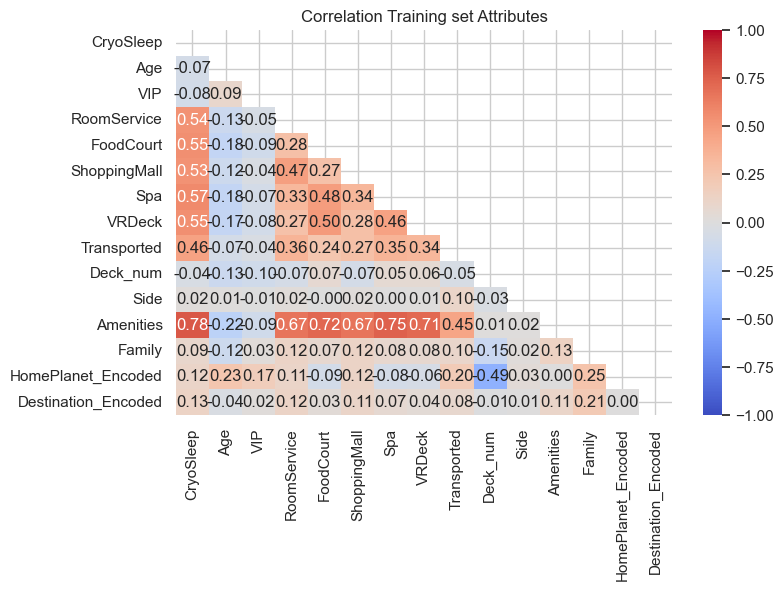

In [138]:
help_tool.heatmap(train, 'Training Set', 'pearson')

In [139]:
test = cleaning(test)
test.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck_num,Side,Amenities,Family,HomePlanet_Encoded,Destination_Encoded
0,0.0,18.0,0.0,0,0,1,1,1,817.0,1,3,0,1,1.0
1,0.0,23.0,0.0,0,0,1,1,0,281.0,1,2,0,1,2.0
2,0.0,25.0,0.0,0,1,0,1,1,383.0,0,3,0,1,2.0
3,0.0,21.0,0.0,1,1,1,0,0,372.0,0,3,1,1,1.0
4,0.0,24.0,0.0,1,1,0,0,0,372.0,0,2,1,1,1.0


In [140]:
#train[amenities] = np.log1p(train[amenities])

In [141]:
train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck_num,Side,Amenities,Family,HomePlanet_Encoded,Destination_Encoded
0,0.0,31.0,0.0,0,0,0,0,1,False,263.0,0,1,0,1,1.0
1,0.0,16.0,0.0,0,0,0,1,1,True,460.0,1,2,1,1,2.0
2,0.0,15.0,0.0,1,1,1,0,0,False,460.0,1,3,1,1,2.0
3,0.0,39.0,0.0,0,0,1,1,1,False,460.0,1,3,1,1,2.0
4,1.0,27.0,0.0,1,1,1,1,1,False,152.0,1,5,0,1,1.0


In [144]:
amenities = amenities + ['Amenities']

Amenities


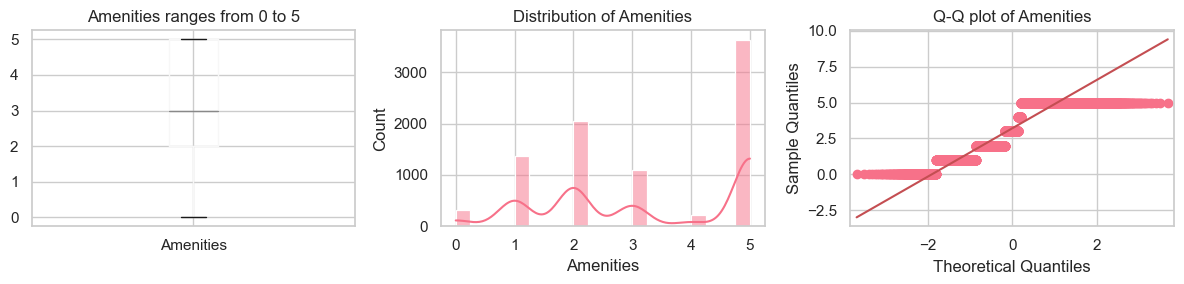

In [146]:
help_tool.distribution_check(train[['Amenities']])

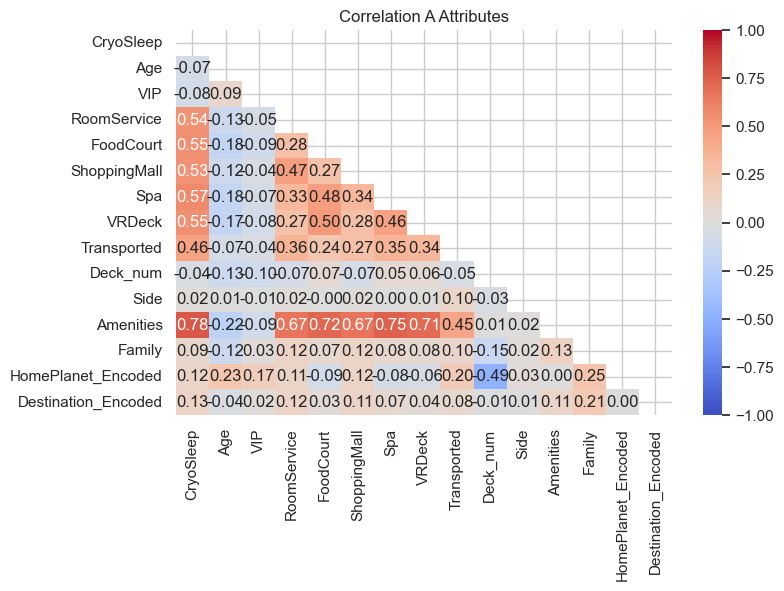

In [147]:
help_tool.heatmap(train, 'a', 'pearson')

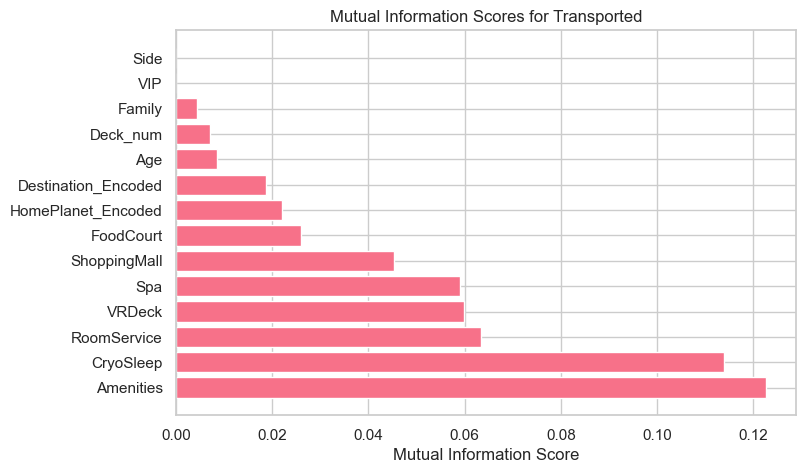

In [148]:
X = train.drop(['Transported'], axis=1)
y = train['Transported']

# Compute mutual information scores
mi_scores = pd.DataFrame(mutual_info_classif(
    X, y), index=X.columns, columns=['Mutual Information Gain'])
mi_scores.sort_values(by='Mutual Information Gain',
                      ascending=False, inplace=True)

# Visualize the scores
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)

plt.figure(dpi=100, figsize=(8, 5))
plt.barh(width, mi_scores['Mutual Information Gain'])
plt.yticks(width, ticks)
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information Scores for Transported")
plt.show()

In [149]:
train[train['CryoSleep'] == 0]['Amenities'].value_counts()

2    2057
1    1370
3    1096
5     600
0     311
4     222
Name: Amenities, dtype: int64

In [150]:
train[train['CryoSleep'] == 1][amenities].value_counts()

RoomService  FoodCourt  ShoppingMall  Spa  VRDeck  Amenities
1            1          1             1    1       5            3037
dtype: int64

# Model

In [157]:
train['Transported'] = train['Transported'].astype(int)

In [161]:
train['Transported']

0       0
1       1
2       0
3       0
4       0
       ..
8688    1
8689    1
8690    1
8691    1
8692    1
Name: Transported, Length: 8693, dtype: int32

In [170]:
X = train.drop('Transported', axis=1)
y = train['Transported']


(X_train, X_validation, y_train, y_validation) = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


X_test = test


In [171]:
X_train.shape

(6085, 14)

## Hyperparameted  tuning

In [167]:
models = {
    'Radial SVM': (SVC(kernel='rbf', probability=False), {'C': (0.1, 100), 'gamma': (0.01, 10)}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': list(range(1, 11))}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': list(range(10, 101, 10)), 'max_depth': list(range(1, 11))}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': list(range(2, 11)), 'weights': ['uniform', 'distance'], 'p': [1, 2]}),
    'Naive Bayes': (GaussianNB(), {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}),
    'XGBoost': (XGBClassifier(), {'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01], 'n_estimators': [100, 200]})
}


for model_name, (model, param_grid) in models.items():
    # Random search for the current model
    random_search = RandomizedSearchCV(
        estimator=model, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=5, random_state=42)
    random_search.fit(X_train, y_train)

    # Best hyperparameters
    best_params = random_search.best_params_

    # New models with the best hyperparameters
    best_model = model.__class__(**best_params)
    best_model.fit(X_train, y_train)

    # Predictions
    if hasattr(best_model, "predict_proba"):
        predictions = best_model.predict_proba(X_validation)[:, 1]
    else:
        predictions = best_model.decision_function(X_validation)


    # New best models
    if model_name == 'Radial SVM':
        svm = best_model
        svm_param = best_params
    elif model_name == 'Logistic Regression':
        logisticr = best_model
        logisticr_param = best_params
    elif model_name == 'Decision Tree':
        dtree = best_model
        dtree_param = best_params
    elif model_name == 'Random Forest':
        rforest = best_model
        rforest_param = best_params
    elif model_name == 'KNN':
        knn = best_model
        knn_param = best_params
    elif model_name == 'Naive Bayes':
        nb = best_model
        nb_param = best_params
    elif model_name == 'XGBoost':
        xgb = best_model
        xgb_param = best_params

    print(f"Model: {model_name}")
    print(f"Best Hyperparameters: {best_params}")
    print(
        f"Adjusted F1 Score: {accuracy_score(y_validation, predictions):.2f}")

c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model: Radial SVM
Best Hyperparameters: {'gamma': 0.01, 'C': 100}


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [179]:
clf = DecisionTreeClassifier()

# Define the hyperparameter space
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'min_samples_leaf': [1, 2, 4]
}

# Define random search with cross-validation
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=20, cv=10, random_state=42)

# Perform random search to find the best hyperparameters
random_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_clf = random_search.best_estimator_
best_params = random_search.best_params_

# Print the best hyperparameters found
print("Best Hyperparameters:")
print(best_params)

# Evaluate the accuracy of the best model
accuracy = accuracy_score(y_train, best_clf.predict(X_train))
print("Accuracy:", accuracy)

# Evaluate the accuracy of the best model
accuracy = accuracy_score(y_validation, best_clf.predict(X_validation))
print("Accuracy:", accuracy)

Best Hyperparameters:
{'min_samples_split': 100, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'entropy'}
Accuracy: 0.7531635168447001
Accuracy: 0.7423312883435583
